In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import date
from scipy.stats import norm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

### Price Movement Probability
- Purpose: Calculate the probability distribution of a stock's price movement during a defined interval of time
- Why: Understanding the probability distribution of a stock's return can
    - Improve Risk: Return distributions help assess risk. A stock with a wide distribution experiences high variance and this price swings
    - Forecast: Understanding the distributio enables traders to forecast the likelihood of a stock increasing by X%
- Definitions
    -Mu (Mean): the mean or average return of a stock
    - Sigma (Standard Deviation): Measure of variability. Captures how much the return fluctuates around the average return (risk). A higher sigma means higher risk; lowr sigma means lower risk

In [ ]:
# Download historical data
ticker = 'SPY'
df = yf.download(ticker, period = '10y', interval = '1d', multi_level_index = False)
df

/tmp/ipython-input-866798296.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period = '10y', interval = '1d', multi_level_index = False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2015-08-06,175.633652,177.378601,175.043560,177.269011,116030800
2015-08-07,175.296448,175.625207,174.386034,175.473478,117858000
2015-08-10,177.505035,177.589325,176.417592,176.417592,80270700
2015-08-11,175.903351,176.577732,175.136242,176.156246,126081400
2015-08-12,176.114136,176.299591,173.113150,174.588355,172123700
...,...,...,...,...,...
2025-07-31,632.080017,639.849976,630.770020,639.460022,103385200
2025-08-01,621.719971,626.340027,619.289978,626.299988,140103600
2025-08-04,631.169983,631.219971,625.580017,625.669983,73218000


In [ ]:
# Turn historical data into weekly segments
weekly_data = df.resample('W').agg({'Close':['first', 'last']})
weekly_data.columns = ['start_of_week_price', 'end_of_week_price']
weekly_data['start_of_week'] = weekly_data.index - pd.offsets.Week(weekday = 0) + pd.offsets.BDay(0)
weekly_data['end_of_week'] = weekly_data.index - pd.offsets.Week(weekday = 4) + pd.offsets.BDay(0)
weekly_data['PriceChange'] = weekly_data['end_of_week_price'] - weekly_data['start_of_week_price']
weekly_data['PercentChange'] = (weekly_data['PriceChange'] / weekly_data['start_of_week_price'])*100
weekly_data

,start_of_week_price,end_of_week_price,start_of_week,end_of_week,PriceChange,PercentChange
Date,,,,,,
2015-08-09,175.633652,175.296448,2015-08-03,2015-08-07,-0.337204,-0.191993
2015-08-16,177.505035,176.535629,2015-08-10,2015-08-14,-0.969406,-0.546129
2015-08-23,177.521881,166.765518,2015-08-17,2015-08-21,-10.756363,-6.059176
2015-08-30,159.743607,167.987885,2015-08-24,2015-08-28,8.244278,5.160944
2015-09-06,166.630676,162.348297,2015-08-31,2015-09-04,-4.282379,-2.569982
...,...,...,...,...,...,...
2025-07-13,620.679993,623.619995,2025-07-07,2025-07-11,2.940002,0.473674
2025-07-20,624.809998,627.580017,2025-07-14,2025-07-18,2.770020,0.443338
2025-07-27,628.770020,637.099976,2025-07-21,2025-07-25,8.329956,1.324802


## Plot Stock Return Probability Distribution

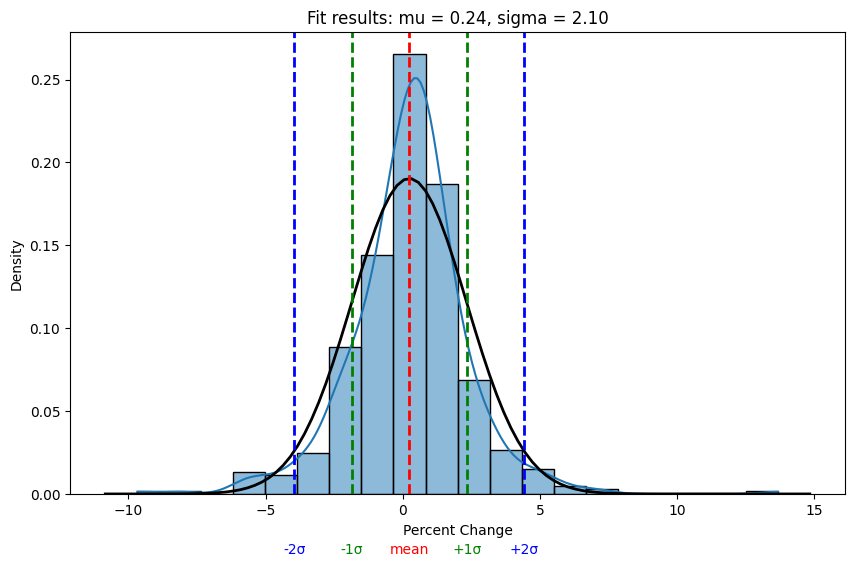

In [ ]:
percent_changes = weekly_data['PercentChange'].dropna()

# Plot histogram
plt.figure(figsize = (10, 6))
sns.histplot(percent_changes, bins = 20, kde = True, stat = 'density')

(mu, sigma) = norm.fit(percent_changes)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth = 2)
plt.axvline(mu, color = 'r', linestyle = 'dashed', linewidth = 2)
plt.axvline(mu + sigma, color = 'g', linestyle = 'dashed', linewidth = 2)
plt.axvline(mu + (2*sigma), color = 'b', linestyle = 'dashed', linewidth = 2)
plt.axvline(mu - sigma, color = 'g', linestyle = 'dashed', linewidth = 2)
plt.axvline(mu - (2*sigma), color = 'b', linestyle = 'dashed', linewidth = 2)

# Adding labels
plt.text(mu, plt.ylim()[1] *-0.13, 'mean', color = 'r', ha = 'center')
plt.text(mu + sigma, plt.ylim()[1] *-0.13, '+1σ', color = 'g', ha = 'center')
plt.text(mu - sigma, plt.ylim()[1] *-0.13, '-1σ', color = 'g', ha = 'center')
plt.text(mu + (2*sigma), plt.ylim()[1] *-0.13, '+2σ', color = 'b', ha = 'center')
plt.text(mu - (2*sigma), plt.ylim()[1] *-0.13, '-2σ', color = 'b', ha = 'center')
title = 'Fit results: mu = %.2f, sigma = %.2f' % (mu, sigma)
plt.title(title)
plt.xlabel('Percent Change')
plt.ylabel('Density')

plt.show()
# 68% of the data resides between the green lines (1 stand dev.), and 95% of the data resides in between the blue lines (2 stand dev.)

In [ ]:
threshold = 1

probability = norm.sf(threshold, loc = mu, scale = sigma)
print(f"The probability of {ticker} stock going up more than {threshold}% in one week is {round(probability*100, 1):.1f}%")

The probability of SPY stock going up more than 1% in one week is 35.8%


### Conditional Expectation

In [ ]:
# Shift PercentChange to get previous week's change
weekly_data['PrevWeekChange'] = weekly_data['PercentChange'].shift(1)

# Drop NaN
weekly_data = weekly_data.dropna(subset = ['PrevWeekChange'])
weekly_data

,start_of_week_price,end_of_week_price,start_of_week,end_of_week,PriceChange,PercentChange,PrevWeekChange
Date,,,,,,,
2015-08-16,177.505035,176.535629,2015-08-10,2015-08-14,-0.969406,-0.546129,-0.191993
2015-08-23,177.521881,166.765518,2015-08-17,2015-08-21,-10.756363,-6.059176,-0.546129
2015-08-30,159.743607,167.987885,2015-08-24,2015-08-28,8.244278,5.160944,-6.059176
2015-09-06,166.630676,162.348297,2015-08-31,2015-09-04,-4.282379,-2.569982,5.160944
2015-09-13,166.428375,165.846695,2015-09-07,2015-09-11,-0.581680,-0.349508,-2.569982
...,...,...,...,...,...,...,...
2025-07-13,620.679993,623.619995,2025-07-07,2025-07-11,2.940002,0.473674,1.212277
2025-07-20,624.809998,627.580017,2025-07-14,2025-07-18,2.770020,0.443338,0.473674
2025-07-27,628.770020,637.099976,2025-07-21,2025-07-25,8.329956,1.324802,0.443338


### Weekly conditional Expectation of Stock Returns

In [ ]:
dict_expected_change = {}
dict_std_deviation = {}

condition = weekly_data['PrevWeekChange'] < -5
conditional_expected_change = weekly_data.loc[condition, 'PercentChange'].mean()
dict_expected_change[f'Prev <-5%'] = conditional_expected_change

std_dev = weekly_data.loc[condition, 'PercentChange'].std()
dict_std_deviation[f'Prev <-5%'] = std_dev

prevReturn = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
for i in prevReturn:
    if i == 5:
        condition = weekly_data['PrevWeekChange'] >= i
    else:
        condition = (weekly_data['PrevWeekChange'] >= i) & (weekly_data['PrevWeekChange'] < i+1)

    #Calc cond. exp. percent change
    conditional_expected_change = weekly_data.loc[condition, 'PercentChange'].mean()
    std_dev = weekly_data.loc[condition, 'PercentChange'].std()

    if i == 5:
        dict_expected_change[f'Prev >{i}%'] = conditional_expected_change
        dict_std_deviation[f'Prev >{i}%'] = std_dev
    else:
        dict_expected_change[f'Prev [{i},{i+1}]%'] = conditional_expected_change
        dict_std_deviation[f'Prev [{i},{i+1}]%'] = std_dev

print(f'Prev <-5%', 'Mean:', round(float(dict_expected_change[f'Prev <-5%']), 2), 'Volatility:',round(float(dict_std_deviation[f'Prev <-5%']), 2))
for i in prevReturn:
    if i == 5:
        print(f'Prev >{i}%', 'Mean:', round(float(dict_expected_change[f'Prev >{i}%']), 2), 'Volatility:',round(float(dict_std_deviation[f'Prev >{i}%']), 2))
    else:
        print(f'Prev [{i}%,{i+1}%]', 'Mean:', round(float(dict_expected_change[f'Prev [{i},{i+1}]%']), 2), 'Volatility:', round(float(dict_std_deviation[f'Prev [{i},{i+1}]%']), 2))


Prev <-5% Mean: 0.83 Volatility: 4.28
Prev [-5%,-4%] Mean: 2.24 Volatility: 5.75
Prev [-4%,-3%] Mean: 0.13 Volatility: 3.96
Prev [-3%,-2%] Mean: 1.56 Volatility: 2.41
Prev [-2%,-1%] Mean: 0.19 Volatility: 2.31
Prev [-1%,0%] Mean: -0.18 Volatility: 1.97
Prev [0%,1%] Mean: 0.28 Volatility: 1.5
Prev [1%,2%] Mean: 0.29 Volatility: 1.57
Prev [2%,3%] Mean: 0.03 Volatility: 1.2
Prev [3%,4%] Mean: -0.06 Volatility: 2.32
Prev [4%,5%] Mean: -1.58 Volatility: 2.65
Prev >5% Mean: 0.3 Volatility: 2.99


- Mean is the average percentage amount the stock is likely to change this week given that last week changed X amount
- Volatility is the fluctuation the percentage could go up or down based on the mean

In [ ]:
weekly_data.tail(1)

,start_of_week_price,end_of_week_price,start_of_week,end_of_week,PriceChange,PercentChange,PrevWeekChange
Date,,,,,,,
2025-08-10,631.169983,632.96991,2025-08-04,2025-08-08,1.799927,0.285173,-2.389555


In [ ]:
last_price = weekly_data['end_of_week_price'].iloc[-1]
nw_stock_price = last_price + (last_price * dict_expected_change['Prev <-5%']/100)
round(float(nw_stock_price), 2) # Expected Ticker price at the end of this week.

638.25

In [ ]:
prevWeekPercent = 'Prev [-3,-2]%'
for i in range(0, 8):
    probability = norm.sf(i, loc = dict_expected_change[prevWeekPercent], scale = dict_std_deviation[prevWeekPercent])
    probability = round(float(probability*100), 2)
    print(f'There is a {probability}% chance that {ticker} goes up {i}% given that {prevWeekPercent}')

There is a 74.14% chance that SPY goes up 0% given that Prev [-3,-2]%
There is a 59.22% chance that SPY goes up 1% given that Prev [-3,-2]%
There is a 42.8% chance that SPY goes up 2% given that Prev [-3,-2]%
There is a 27.56% chance that SPY goes up 3% given that Prev [-3,-2]%
There is a 15.62% chance that SPY goes up 4% given that Prev [-3,-2]%
There is a 7.71% chance that SPY goes up 5% given that Prev [-3,-2]%
There is a 3.29% chance that SPY goes up 6% given that Prev [-3,-2]%
There is a 1.21% chance that SPY goes up 7% given that Prev [-3,-2]%


In [ ]:
ranges = [-np.inf, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, np.inf]

labels = ["< -5%", "5% to 4%", "-4% to -3%", "-3% to -2%", "-2% to -1%", "-1% to 0%", "0% to 1%", "1% to 2%", "2% to 3%", "3% to 4%", "4% to 5%", "> 5%"]

weekly_data['PrevBin'] = pd.cut(weekly_data['PrevWeekChange'], bins = ranges, labels = labels)
weekly_data['CurrentBins'] = pd.cut(weekly_data['PercentChange'], bins = ranges, labels = labels)

prob_df = pd.DataFrame(index = labels, columns = labels)
count_df = pd.DataFrame(index = labels, columns= labels)

# Nested For Loop to Calc Probs for each combination of PrevBin and CurrentBin
for prev_bin in labels:
    for current_bin in labels:
        num_joint = len(weekly_data[(weekly_data['PrevBin'] == prev_bin) & (weekly_data["CurrentBins"] == current_bin)])
        num_prev = len(weekly_data[weekly_data["PrevBin"] == prev_bin])
        count_df.loc[prev_bin, current_bin] = num_joint
        prob = num_joint / num_prev if num_prev > 0 else 0
        prob_df.loc[prev_bin, current_bin] = prob

count_df = count_df.astype(int)
prob_df = round(prob_df.astype(float), 2)

# Negative Return bins include percentage changes ess than or equal to 0%
negative_return = ["< -5%", "5% to 4%", "-4% to -3%", "-3% to -2%", "-2% to -1%", "-1% to 0%"]

# Positive Return bins incluide percentage changes greater than 0%
positive_return = ["0% to 1%", "1% to 2%", "2% to 3%", "3% to 4%", "4% to 5%", "> 5%"]

prob_df["Negative"] = prob_df[negative_return].sum(axis = 1)
prob_df["Positive"] = prob_df[positive_return].sum(axis = 1)

count_df["Negative"] = count_df[negative_return].sum(axis = 1)
count_df["Positive"] = count_df[positive_return].sum(axis = 1)

# Calculate the probability of > 1%
prob_df["> 1%"] = prob_df['1% to 2%'] + prob_df['2% to 3%'] + prob_df['3% to 4%'] + prob_df['4% to 5%'] + prob_df['> 5%']

# Calculate the probability of > 2%
prob_df["> 2%"] = prob_df['2% to 3%'] + prob_df['3% to 4%'] + prob_df['4% to 5%'] + prob_df['> 5%']

# Calculate the probability of > 3%
prob_df["> 3%"] = prob_df['3% to 4%'] + prob_df['4% to 5%'] + prob_df['> 5%']

# Calculate the probability of > 4%
prob_df["> 4%"] = prob_df['4% to 5%'] + prob_df['> 5%']

# Calculate the total probability by summing "Positive" and "Negative" columns
prob_df["Total"] = prob_df['Positive'] + prob_df['Negative']

# Calculate the total count by summing "Positive" and "Negative" columns
count_df["Total"] = count_df['Positive'] + count_df['Negative']

/tmp/ipython-input-669744621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_data['PrevBin'] = pd.cut(weekly_data['PrevWeekChange'], bins = ranges, labels = labels)
/tmp/ipython-input-669744621.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_data['CurrentBins'] = pd.cut(weekly_data['PercentChange'], bins = ranges, labels = labels)


In [ ]:
prob_df

,< -5%,5% to 4%,-4% to -3%,-3% to -2%,-2% to -1%,-1% to 0%,0% to 1%,1% to 2%,2% to 3%,3% to 4%,4% to 5%,> 5%,Negative,Positive,> 1%,> 2%,> 3%,> 4%,Total
< -5%,0.10,0.00,0.10,0.10,0.20,0.00,0.10,0.00,0.00,0.00,0.00,0.40,0.50,0.50,0.40,0.40,0.40,0.40,1.00
5% to 4%,0.00,0.00,0.00,0.17,0.00,0.17,0.33,0.17,0.00,0.00,0.00,0.17,0.34,0.67,0.34,0.17,0.17,0.17,1.01
-4% to -3%,0.08,0.00,0.00,0.08,0.08,0.25,0.08,0.00,0.17,0.17,0.00,0.08,0.49,0.50,0.42,0.42,0.25,0.08,0.99
-3% to -2%,0.00,0.00,0.03,0.00,0.09,0.16,0.16,0.16,0.12,0.06,0.16,0.06,0.28,0.72,0.56,0.40,0.28,0.22,1.00
-2% to -1%,0.02,0.05,0.02,0.07,0.15,0.09,0.22,0.20,0.05,0.09,0.04,0.00,0.40,0.60,0.38,0.18,0.13,0.04,1.00
-1% to 0%,0.03,0.02,0.02,0.07,0.14,0.20,0.23,0.18,0.11,0.00,0.00,0.00,0.48,0.52,0.29,0.11,0.00,0.00,1.00
0% to 1%,0.00,0.00,0.02,0.06,0.09,0.20,0.33,0.21,0.04,0.03,0.00,0.01,0.37,0.62,0.29,0.08,0.04,0.01,0.99
1% to 2%,0.00,0.01,0.04,0.03,0.03,0.24,0.40,0.12,0.08,0.02,0.01,0.00,0.35,0.63,0.23,0.11,0.03,0.01,0.98
2% to 3%,0.00,0.00,0.00,0.03,0.22,0.16,0.38,0.16,0.05,0.00,0.00,0.00,0.41,0.59,0.21,0.05,0.00,0.00,1.00
3% to 4%,0.06,0.00,0.00,0.11,0.11,0.22,0.17,0.22,0.00,0.06,0.06,0.00,0.50,0.51,0.34,0.12,0.12,0.06,1.01


In [ ]:
count_df

,< -5%,5% to 4%,-4% to -3%,-3% to -2%,-2% to -1%,-1% to 0%,0% to 1%,1% to 2%,2% to 3%,3% to 4%,4% to 5%,> 5%,Negative,Positive,Total
< -5%,1,0,1,1,2,0,1,0,0,0,0,4,5,5,10
5% to 4%,0,0,0,1,0,1,2,1,0,0,0,1,2,4,6
-4% to -3%,1,0,0,1,1,3,1,0,2,2,0,1,6,6,12
-3% to -2%,0,0,1,0,3,5,5,5,4,2,5,2,9,23,32
-2% to -1%,1,3,1,4,8,5,12,11,3,5,2,0,22,33,55
-1% to 0%,3,2,2,7,13,19,22,17,11,0,0,0,46,50,96
0% to 1%,0,0,3,9,14,30,49,32,6,5,0,1,56,93,149
1% to 2%,0,1,4,3,3,21,36,11,7,2,1,0,32,57,89
2% to 3%,0,0,0,1,8,6,14,6,2,0,0,0,15,22,37
3% to 4%,1,0,0,2,2,4,3,4,0,1,1,0,9,9,18


## Iron Condor Strategy
- Implied Volatility


In [ ]:
trading_days = 252
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
df['RollingVolatility'] = df['LogReturn'].rolling(window = 20).std()*np.sqrt(trading_days)
df.dropna(inplace = True)
daily_volatility = np.std(df['LogReturn'])
annualized_volatility = daily_volatility*np.sqrt(trading_days)

print(f'Historic Annulaized Volatility for {ticker}: {annualized_volatility: .2%}')

Historic Annulaized Volatility for SPY:  18.21%


In [ ]:
start_value = weekly_data['start_of_week_price'].iloc[-1]
print("Start Value: ", start_value)

last_percent_change = weekly_data['PrevWeekChange'].iloc[-1]
print("Given that last week % was: ", last_percent_change)

last_percent_change_label = weekly_data['PrevBin'].iloc[-1]
print(last_percent_change_label)

def sum_probabilites(df, row_index, start_column, end_column):
    row = df.loc[row_index]
    columns = list(df.columns)
    start_index = columns.index(start_column)
    end_index = columns.index(end_column)

    # Sum probs between the selected columns
    if start_index <= end_index:
        sum_prob = row.iloc[start_index:end_index+1].sum()
    else:
        raise ValueError("Start column mst come before the end column")
    return sum_prob

# Choose the columns to be in between our range. If we do a range of 1, we do (-1% to 0%)[Sell Put] and (0% to 1%)[Sell Call]
sum_prob = sum_probabilites(df = prob_df, row_index = last_percent_change_label, start_column= '-1% to 0%', end_column = '0% to 1%')
print(float(sum_prob*100), "%")

Start Value:  631.1699829101562
Given that last week % was:  -2.389555009882015
-3% to -2%
32.0 %


In [ ]:
sell_call_strike = math.ceil((start_value*0.01)+start_value)
sell_put_strike = math.floor((start_value*-0.01)+start_value)
buy_call_strike = sell_call_strike+1
buy_put_strike = sell_put_strike-1

iron_condor = {
    'Buy Call Strike': buy_call_strike,
    'Sell Call Strike': sell_call_strike,
    'Sell Put Strike': sell_put_strike,
    'Buy Put Strike': buy_put_strike
}

iron_condor

{'Buy Call Strike': 639,
 'Sell Call Strike': 638,
 'Sell Put Strike': 624,
 'Buy Put Strike': 623}

## Download Call and Put Options


In [ ]:
def call_and_put(ticker, exp_date):
    # Get Call Options
    df_call = yf.Ticker(ticker).option_chain(exp_date).calls

    # Get Put Options
    df_put = yf.Ticker(ticker).option_chain(exp_date).puts

    return df_call, df_put

df_call, df_put = call_and_put(ticker = "SPY", exp_date = "2025-08-15")
df_call

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY250815C00245000,2025-07-29 16:42:04+00:00,245.0,391.33,386.02,388.82,0.0,0.0,2,60,2.608402,True,REGULAR,USD
1,SPY250815C00250000,2025-08-04 13:30:12+00:00,250.0,376.09,381.02,383.80,0.0,0.0,1,19,2.547855,True,REGULAR,USD
2,SPY250815C00260000,2025-02-06 17:40:21+00:00,260.0,349.72,317.11,320.27,0.0,0.0,1,4,0.000010,True,REGULAR,USD
3,SPY250815C00265000,2025-08-05 16:30:16+00:00,265.0,365.00,366.05,368.83,0.0,0.0,10,12,2.412113,True,REGULAR,USD
4,SPY250815C00270000,2025-04-07 13:36:57+00:00,270.0,221.25,294.67,297.97,0.0,0.0,1,10,0.000010,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,SPY250815C00810000,2025-08-04 13:30:01+00:00,810.0,0.01,0.00,0.01,0.0,0.0,1,552,0.464849,False,REGULAR,USD
292,SPY250815C00815000,2025-07-09 13:51:15+00:00,815.0,0.02,0.00,0.01,0.0,0.0,1,2757,0.476568,False,REGULAR,USD
293,SPY250815C00820000,2025-07-08 19:30:42+00:00,820.0,0.01,0.00,0.01,0.0,0.0,1,2017,0.484380,False,REGULAR,USD
294,SPY250815C00825000,2025-06-27 17:44:33+00:00,825.0,0.01,0.00,0.01,0.0,0.0,5,1557,0.496099,False,REGULAR,USD


In [ ]:
call_strike_values = set(value for key, value in iron_condor.items() if "Call" in key)
put_strike_values = set(value for key, value in iron_condor.items() if "Put" in key)

# Filter the option chain
condor_calls_df = df_call[df_call['strike'].isin(call_strike_values)]
condor_puts_df = df_put[df_put['strike'].isin(put_strike_values)]

In [ ]:
condor_calls_df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
246,SPY250815C00638000,2025-08-06 17:47:58+00:00,638.0,2.68,2.60,2.62,0.74,38.14433,817,4540,0.112069,False,REGULAR,USD
247,SPY250815C00639000,2025-08-06 17:50:20+00:00,639.0,2.27,2.23,2.25,0.68,42.76729,905,5241,0.110635,False,REGULAR,USD


In [ ]:
condor_puts_df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
233,SPY250815P00623000,2025-08-06 17:46:24+00:00,623.0,2.31,2.39,2.4,-1.60,-40.920720,1016.0,4731,0.148324,False,REGULAR,USD
234,SPY250815P00624000,2025-08-06 17:51:06+00:00,624.0,2.60,2.58,2.6,-1.58,-37.799046,1000.0,6839,0.146249,False,REGULAR,USD


## Net Credit


In [ ]:
sell_call_price = condor_calls_df.loc[condor_calls_df['strike'] == iron_condor['Sell Call Strike'], 'bid'].values[0]
sell_put_price = condor_puts_df.loc[condor_puts_df['strike'] == iron_condor['Sell Put Strike'], 'bid'].values[0]
buy_call_price = condor_calls_df.loc[condor_calls_df['strike'] == iron_condor['Buy Call Strike'], 'ask'].values[0]
buy_put_price = condor_puts_df.loc[condor_puts_df['strike'] == iron_condor['Buy Put Strike'], 'ask'].values[0]

NetCredit = (sell_call_price - buy_call_price) + (sell_put_price - buy_put_price)
print('$', round(float(NetCredit*100), 3))

$ 53.0


# Max Loss

In [ ]:
Spreadwidth = iron_condor['Buy Call Strike'] -iron_condor['Sell Call Strike']
print(Spreadwidth)

Spreadwidth = iron_condor['Sell Put Strike'] -iron_condor['Buy Put Strike']
print(Spreadwidth)

MaxLoss = Spreadwidth - NetCredit
print('-$', round(float(MaxLoss*100), 3))

1
1
-$ 47.0
